# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<hr style='border:2px solid black'>

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

<hr style='border:1px solid black'>

### 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

<hr style='border:.5px solid black'>
</br>
**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
#df = pd.read_csv(r'C:\Users\Lauren\OneDrive - Western Governors University\Intro to Data Science\AB testing project\ab_data.csv')
df = pd.read_csv(r'~/Library/CloudStorage/OneDrive-WesternGovernorsUniversity/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


</br>

**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


> Rows: 294478

</br>

**c.** The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

> Unique ID's: 290584

</br>

**d.** The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

> 11.97% of users converted

</br>

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
df['group'].loc[(df['landing_page'] == 'old_page') & (df['group'] == 'treatment')].count()

1965

> There are <strong>1965</strong> instances where the treatment group viewed the old_page instead of the new page

</br>

**f.** Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

> This data set has no missing values

<hr style='border:1px solid black'>

### 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  

<hr style='border:1px solid navy'>
</br>
**a.** Remove the inaccurate rows and store your new dataframe in **df2**.

In [8]:
df_new1 = df.loc[(df['landing_page'] == 'new_page') & (df['group'] == 'treatment')]
df_new2 = df.loc[(df['landing_page'] == 'old_page') & (df['group'] == 'control')]
df2 = pd.concat([df_new1, df_new2], axis=0, join='outer')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 2 to 294476
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


> 3,893 rows were removed where the group and landing_page were mismatched.  

In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

</br>

In [10]:
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

> The new data frame now only contains the rows were the group and landing page were accurate.

<hr style='border:1px solid black'>

### 1.3  
<hr style='border:1px solid navy'>

**a.** How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

> <strong>df2</strong> contains <strong>290584</strong> unique user ID's

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


</br>

**c.** Display the rows for the duplicate **user_id**? 

In [13]:
df2.loc[(df2['user_id'] == 773192)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


> User ID <strong>773192</strong> has been identified as a duplicate value. It appears on lines <strong>1899</strong> and <strong>2893</strong>.

**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [14]:
df2 = df2.drop_duplicates(subset='user_id', keep='first')

> We used the drop_duplicates function to remove line <strong>2893</strong>.

In [15]:
df2.loc[(df2['user_id'] == 773192)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


> Now user ID <strong>773192</strong> only appears on line <strong>1899</strong>.

<hr style='border:1px solid black'>

### 1.4  
<hr style='border:1px solid navy'>

**a.** What is the probability of an individual converting regardless of the page they receive?

In [16]:
p_pop = df2['converted'].mean()
p_pop

0.11959708724499628

> The overall success rate in converting customers is <strong>11.96%</strong>.

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
df2_c = df2['converted'].loc[(df2['group'] == 'control')].mean()
df2_c

0.1203863045004612

> The success rate in converting customers using the old page is <strong>12.04%</strong>.

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
df2_t = df2['converted'].loc[(df2['group'] == 'treatment')].mean()
df2_t

0.11880806551510564

> The success rate in converting customers using the new page is <strong>11.88%</strong>.

In [19]:
obs_diff = df2_t - df2_c
obs_diff

-0.0015782389853555567

> The actual difference between the treatment and control group is <strong>- 0.1578%</strong>.

**d.** What is the probability that an individual received the new page?

In [20]:
(df2['landing_page'].loc[(df2['landing_page'] == 'new_page')].count()) / df2['landing_page'].count()

0.5000619442226688

> There is a <strong>50.006%</strong> chance that an individual will receive the new page.

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>As the probability of receiving either the new or old page is roughly <strong>50%</strong> for each, we will only consider the conversion rates calculated above.  The treatment group shows a lower conversion rate than the control group at <strong>11.88%</strong>, while the control group's conversion rate is <strong>12.04%</strong>.

<hr style='border:2px solid black'>

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  
<hr style='border:1px solid black'>

### 2.1
For now, consider you need to make the decision just based on all the data provided.  

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  


> **$H_{0}$** : **$p_{new}$** $\le$ **$p_{old}$**
<br />
**$H_{1}$** :  **$p_{new}$** $>$ **$p_{old}$**

<hr style='border:1px solid black'>

### 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

<hr style='border:1px solid navy'>

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [21]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

> The conversion rate for  $p_{new}$ under the null hypothesis is <strong>11.96%</strong>.

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [22]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

> The conversion rate for  $p_{old}$ under the null hypothesis is <strong>11.96%</strong>.

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [23]:
n_new = df2['landing_page'].loc[(df2['landing_page'] == 'new_page')].count()
n_new 

145310

> There are <strong>145310</strong> users in $n_{new}$ treatment group.

**d.** What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old = df2['landing_page'].loc[(df2['landing_page'] == 'old_page')].count()
n_old 

145274

> There are <strong>145274</strong> users in $n_{old}$ control group. 
</br>

**e. Simulate Sample for the `treatment` Group**<br> 

In [25]:
new_page_converted = np.random.choice([0,1], size = n_new, p = [1 - p_new, p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

In [26]:
new_page_converted.mean()

0.12028766086298259

> The simulated conversion rate for  $p_{new}$ under the null hypothesis is <strong>11.98%</strong>.

**f. Simulate Sample for the `control` Group** <br>

In [27]:
old_page_converted = np.random.choice([0,1], size = n_old, p = [1 - p_old, p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

In [28]:
old_page_converted.mean()

0.12043448930985585

> The simulated conversion rate for  $p_{old}$ under the null hypothesis is <strong>12.01%</strong>.

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [29]:
new_page_converted.mean() - old_page_converted.mean()

-0.00014682844687326224

> The simulated difference between the two groups is <strong>0.098%</strong>.


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [30]:
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice([0,1], size = n_new, p = [1 - p_new, p_new])
    old_page_converted = np.random.choice([0,1], size = n_old, p = [1 - p_old, p_old])
    diff_hold = new_page_converted.mean()-old_page_converted.mean()
    p_diffs.append((diff_hold))

#converting to an array
p_diffs = np.array(p_diffs)

In [31]:
p_diffs.mean()

-1.1482763009865979e-05

> The simulated difference between the new and old page is <strong>0.0016%</strong>.

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

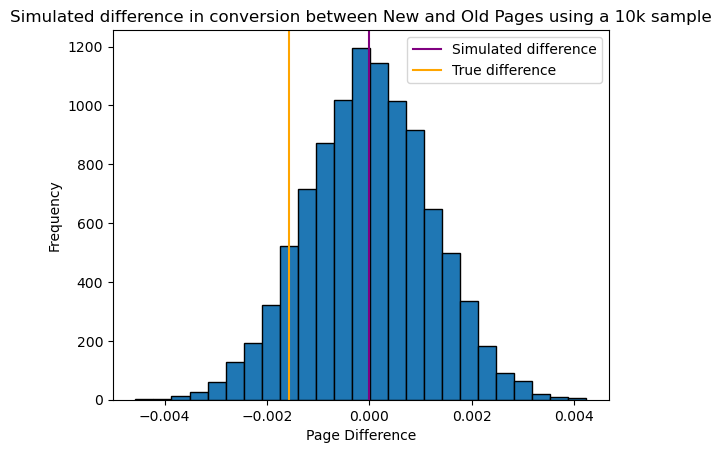

In [32]:
plt.hist(p_diffs, bins=25, edgecolor = 'black')
plt.axvline(p_diffs.mean(), color='purple')
plt.axvline(x=obs_diff, color='orange');

plt.title('Simulated difference in conversion between New and Old Pages using a 10k sample')
plt.xlabel('Page Difference')
plt.ylabel('Frequency')
labels = ['Simulated difference', 'True difference']
plt.legend(labels, loc='best')

plt.show()

In [33]:
(p_diffs < 0).mean()

0.5038

</br>

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [34]:
(p_diffs > obs_diff).mean()

0.9034

> The p_value is <strong>0.9092</strong>.

**k.** Please explain in words what you have just computed in part **j** above.  

>If we were to switch from the Old page to the New page, we would want to see a low p_value. As our p_value is 0.9092, we have failed to reject our hypothesis as the maximum acceptable error rate is 0.05. 



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


</br>

In [35]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2['converted'].loc[(df2['landing_page'] == 'old_page') & (df2['converted'] == 1)].count()

# number of conversions with the new_page
convert_new = df2['converted'].loc[(df2['landing_page'] == 'new_page') & (df2['converted'] == 1)].count()

# number of individuals who were shown the old_page
n_old = df2['group'].loc[(df2['landing_page'] == 'old_page')].count()

# number of individuals who received new_page
n_new = df2['group'].loc[(df2['landing_page'] == 'new_page')].count()


</br>

In [36]:
print(convert_old , convert_new, n_old, n_new)

17489 17264 145274 145310


</br>

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.

In [37]:
import statsmodels.api as sm

z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


</br>

**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br>

> The z-score findings are in line with our previous results. With a z-score value of 1.31, are confidence level is 90.49%. This means we have failed to reject our hypothesis.

Source: https://www.craftonhills.edu/current-students/tutoring-center/mathematics-tutoring/distribution_tables_normal_studentt_chisquared.pdf

<hr style='border:2px solid black'>

<a id='regression'></a>
### Part III - A regression approach

### 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>As we are evaluating a categorical variable, we will use logistic regression.

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [38]:
df_reg = df2
df_reg['intercept'] = 1
df_reg['ab_page'] = pd.get_dummies(df_reg['landing_page'])['new_page']
df_reg

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1
...,...,...,...,...,...,...,...
294471,718310,2017-01-21 22:44:20.378320,control,old_page,0,1,0
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0


</br>

**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [39]:
r_model = sm.Logit(df_reg['converted'],df_reg[['intercept','ab_page']])

result_r = r_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


</br>

**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [40]:
result_r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 16 Apr 2023   Pseudo R-squ.:               8.077e-06
Time:                        19:15:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

</br>

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  


> Hypotheses for the above regression model </br>
> **$H_{0}$** : **$p_{new}$** = **$p_{old}$**
<br />
**$H_{1}$** :  **$p_{new}$** $\ne$ **$p_{old}$**

> This differs from the original hypotheses as the regression hypotheses are only looking if the conversion rate for $p_{new}$ and $p_{old}$ are the same or different but the previous hypotheses were looking at which page had the higher conversion rate

>As our p_value for ab_page is 0.19, we have, again, failed to reject our hypothesis as the maximum acceptable error rate is 0.05

</br>

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> Adding variables such as demographic information could enrich the conversion rate findings. However, adding irrelevant variables, such as if their eye color is blue, could provide skewed results and muddy the findings.

</br>

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

</br>

In [42]:
df_countries = pd.read_csv(r'~/Library/CloudStorage/OneDrive-WesternGovernorsUniversity/countries.csv')
df_countries

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK
...,...,...
290579,653118,US
290580,878226,UK
290581,799368,UK
290582,655535,CA


</br>

In [43]:
df_merged = df2.merge(df_countries, on ="user_id", how = "inner")
df_merged

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA
...,...,...,...,...,...,...,...,...
290579,718310,2017-01-21 22:44:20.378320,control,old_page,0,1,0,US
290580,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0,US
290581,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0,US
290582,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0,US


</br>

In [44]:
df_merged = pd.get_dummies(df_merged, columns = ['country'],prefix = '',prefix_sep='', drop_first = False)
df_merged 

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,1,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
290579,718310,2017-01-21 22:44:20.378320,control,old_page,0,1,0,0,0,1
290580,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0,0,0,1
290581,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0,0,0,1
290582,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0,0,0,1


</br>

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 


</br>

In [59]:
df_merged['CA_ab_page'] = df_merged['CA']*df_merged['ab_page']
df_merged['UK_ab_page'] = df_merged['UK']*df_merged['ab_page']
df_merged['US_ab_page'] = df_merged['US']*df_merged['ab_page']
df_merged

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,CA_ab_page,UK_ab_page,US_ab_page
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1,0,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1,0,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,1,0,0,1,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,1,0,0,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
290579,718310,2017-01-21 22:44:20.378320,control,old_page,0,1,0,0,0,1,0,0,0
290580,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0,0,0,1,0,0,0
290581,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0,0,0,1,0,0,0
290582,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0,0,0,1,0,0,0


In [60]:
# Fit your model, and summarize the results
r_model_ca = sm.Logit(df_merged['converted'],df_merged[['intercept','CA_ab_page', 'CA',]])
result_ca = r_model_ca.fit()

r_model_uk = sm.Logit(df_merged['converted'],df_merged[['intercept','UK_ab_page', 'UK']])
result_uk = r_model_uk.fit()

r_model_us = sm.Logit(df_merged['converted'],df_merged[['intercept','US_ab_page', 'US']])
result_us = r_model_us.fit()

Optimization terminated successfully.
         Current function value: 0.366114
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


</br>

In [61]:
result_ca.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 16 Apr 2023   Pseudo R-squ.:               2.050e-05
Time:                        19:44:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1129
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9941      0.006   -340.272      0.000      -2.006      -1.983
CA_ab_page    -0.0674      0.052     -1.297      0.195      -0.169       0.034
CA            -0.0099      0.037     -0.268      0.789      -0.082       0.062
==============================================================================
"""

</br>

In [62]:
result_uk.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 16 Apr 2023   Pseudo R-squ.:               5.340e-06
Time:                        19:44:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.5666
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9994      0.007   -302.640      0.000      -2.012      -1.986
UK_ab_page     0.0108      0.023      0.475      0.635      -0.034       0.056
UK             0.0072      0.017      0.412      0.681      -0.027       0.041
==============================================================================
"""

In [63]:
result_us.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 16 Apr 2023   Pseudo R-squ.:               1.072e-05
Time:                        19:44:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.3195
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9951      0.010   -190.998      0.000      -2.016      -1.975
US_ab_page    -0.0206      0.014     -1.505      0.132      -0.047       0.006
US             0.0087      0.014      0.609      0.542      -0.019       0.036
==============================================================================
"""

**Adding the country did not affect our previous findings.  Looking at Canada, the United Kingdom, and the United States, the p_values for all three, 0.195, 0.635 and 0.132, were over the maximum acceptable error of 0.05.**